In [25]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

In [2]:
sns.set_style('whitegrid')

In [3]:
# census = pd.read_parquet('data/refined/census_data.parquet')

In [4]:
df_mailout = pd.read_parquet('data/refined/mailout_train.parquet')

# Response variable

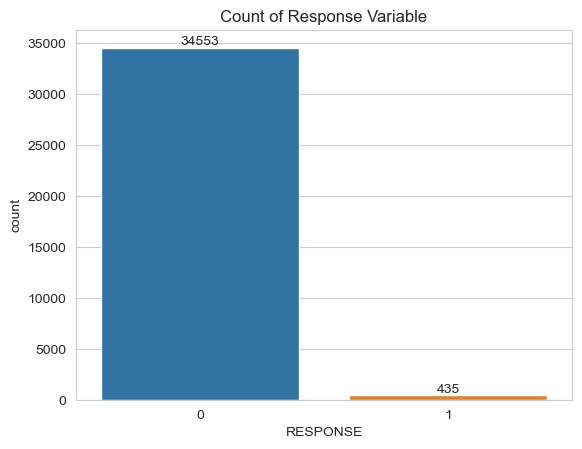

In [5]:
g = sns.countplot(data = df_mailout,
                    x = 'RESPONSE')

g.bar_label(g.containers[-1])

plt.title('Count of Response Variable')

plt.show()

In [6]:
df_mailout['RESPONSE'].value_counts(normalize = True)

0    0.987567
1    0.012433
Name: RESPONSE, dtype: float64

The data is HEAVILY imbalanced. A little more than 1% actually responded to the mailing.  
This is not inherently bad. Some methods can be used like up- or downsampling but not necessairly.  
Either way, given this hard imbalace, accuracy should not be used since in this context it is a biased metric

# Segmenting variable types

In [7]:
census_var_types = pd.read_csv('data/trusted/census_var_types.csv').drop(columns='Unnamed: 0')

In [8]:
census_var_types.head()

,Attribute,Type
0,ALTERSKATEGORIE_GROB,interval
1,ANREDE_KZ,binary
2,ANZ_HAUSHALTE_AKTIV,numeric
3,ANZ_HH_TITEL,numeric
4,ANZ_PERSONEN,numeric


In [9]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL','Type'] = 'binary'

In [10]:
census_var_types.shape

(194, 2)

In [11]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [12]:
for col in binary_vars:
    
    try:
        print(col, df_mailout[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0. 1.]
GREEN_AVANTGARDE [0 1]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]


In [13]:
df_mailout['ANREDE_KZ'] = df_mailout['ANREDE_KZ'] - 1

df_mailout['VERS_TYP'] = df_mailout['VERS_TYP'] - 1

In [14]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, df_mailout.columns)

In [15]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, df_mailout.columns)

In [16]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [17]:
num_cols = df_mailout.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR','RESPONSE'])

In [18]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == len(df_mailout.columns.drop('RESPONSE'))

# Testing base models
Vanilla models to pick best option for tuning

In [19]:
X_sklearn = df_mailout.drop(columns = ['LNR','RESPONSE'])

X_sklearn = pd.get_dummies(X_sklearn,columns = nominal_vars)

y = df_mailout['RESPONSE']

In [47]:
X_sklearn_train, X_sklearn_test, y_train, y_test = train_test_split(X_sklearn, y, test_size=0.2, random_state=42)

In [40]:
y_train.value_counts(normalize = True)

0    0.98776
1    0.01224
Name: RESPONSE, dtype: float64

In [41]:
y_test.value_counts(normalize = True)

0    0.986474
1    0.013526
Name: RESPONSE, dtype: float64

In [48]:
dt = DecisionTreeClassifier(random_state = 42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

xgb = XGBClassifier(n_jobs = -1, random_state = 42)

In [49]:
skfold = StratifiedKFold(n_splits = 5, random_state = 123, shuffle = True)

In [50]:
# Evaluate models using ROC AUC score and store results in a DataFrame
results_df = pd.DataFrame(columns=['Model', 'Fold', 'ROC AUC Score'])

for i, model in enumerate([dt, rf, xgb]):

    if i == 0:

        model_name = 'Decision Tree'
    
    elif i == 1:

        model_name ='Random Forest'

    else:

        model_name = 'XGBoost'
    
    scores = cross_val_score(model, X_sklearn_train, y_train, cv=skfold, scoring='roc_auc', n_jobs= -1, verbose = 1)

    records = [(model_name,i + 1,score) for i, score in enumerate(scores)]

    frame = pd.DataFrame.from_records(records)

    if i == 0:

        results_df = frame

    else:

        results_df = pd.concat([results_df, frame])

results_df.columns = ['Model','fold','roc_auc']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.8s remaining:   40.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.0s finished


In [51]:
display(results_df)

,Model,fold,roc_auc
0,Decision Tree,1,0.521805
1,Decision Tree,2,0.507061
2,Decision Tree,3,0.526638
3,Decision Tree,4,0.491139
4,Decision Tree,5,0.506116
0,Random Forest,1,0.560618
1,Random Forest,2,0.522036
2,Random Forest,3,0.514596
3,Random Forest,4,0.562025
4,Random Forest,5,0.482451


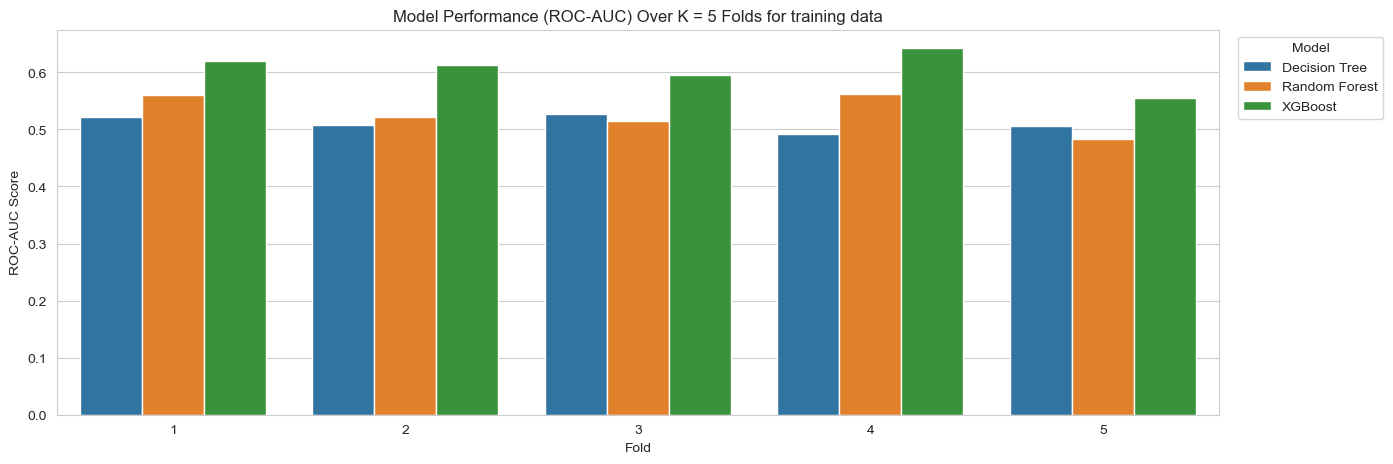

In [52]:
fig, ax = plt.subplots(figsize = (15,5))

sns.barplot(data = results_df,
                    x = 'fold',
                    y = 'roc_auc',
                    hue = 'Model',
                    ax = ax)

ax.set_ylabel('ROC-AUC Score')

ax.set_xlabel('Fold')

plt.legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

plt.title('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

plt.show()

In [53]:
results_df.groupby('Model')['roc_auc'].mean()

Model
Decision Tree    0.510552
Random Forest    0.528345
XGBoost          0.605415
Name: roc_auc, dtype: float64

XGBoost clearly outperforms both models and is actually the only one that has a good distance from 